In [254]:
# Actualizamos los módulos automáticamente
%reload_ext autoreload
%autoreload 2

# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from langdetect import detect#, language_name
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Añadir el directorio scripts al PYTHONPATH
sys.path.append(os.path.abspath("../scripts"))

# Importamos funciones personalizadas
import funciones

# Rutas
ruta_user_reviews = '../data/user_reviews.parquet'

# Carga de datos
user_reviews_df = pd.read_parquet(ruta_user_reviews)

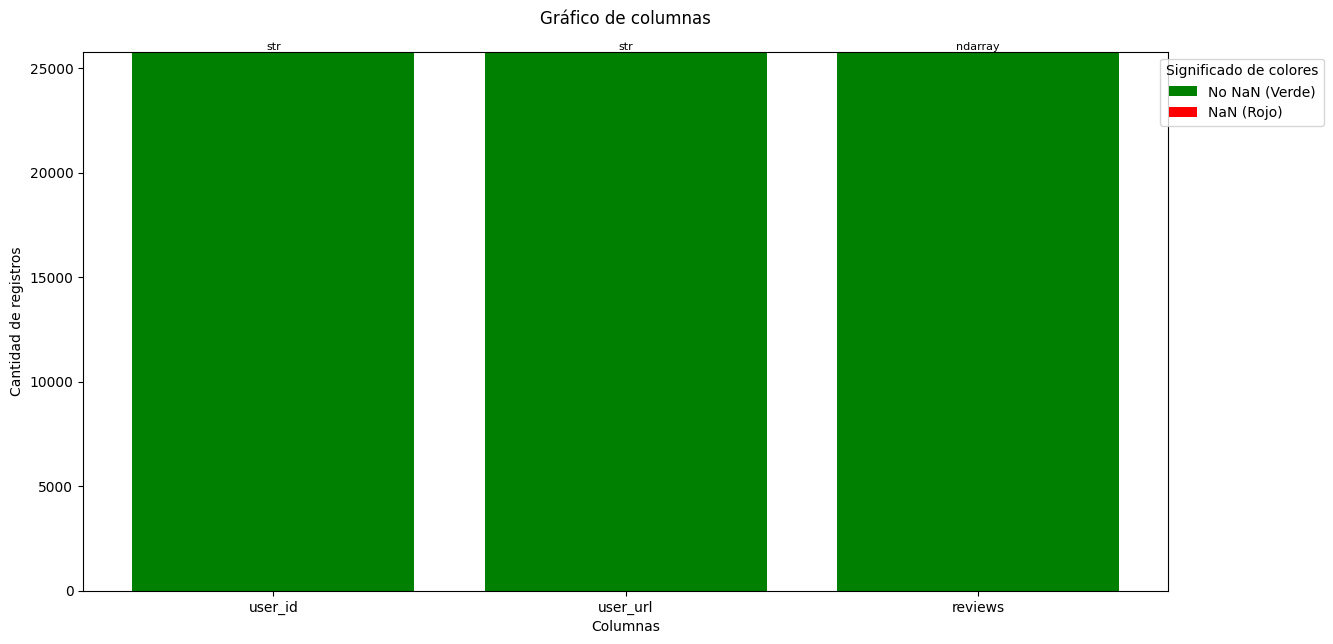

In [255]:
# Visualización inicial
funciones.plot_df_info(user_reviews_df)

In [256]:
# Dimensiones iniciales
user_reviews_df.shape

(25799, 3)

In [257]:
# Pasamos la columna reviews a tipo de dato lista para poder manipularla luego en la desanidación:
user_reviews_df['reviews'] = user_reviews_df['reviews'].apply(lambda x: x.tolist())

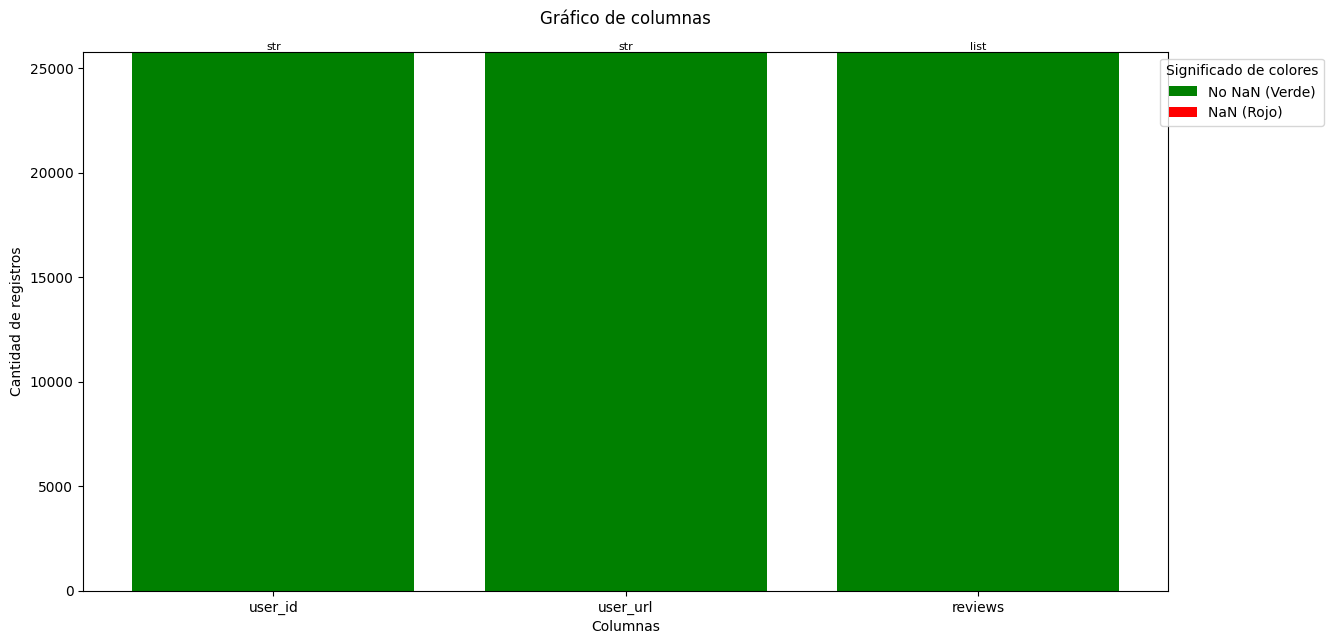

In [258]:
funciones.plot_df_info(user_reviews_df)

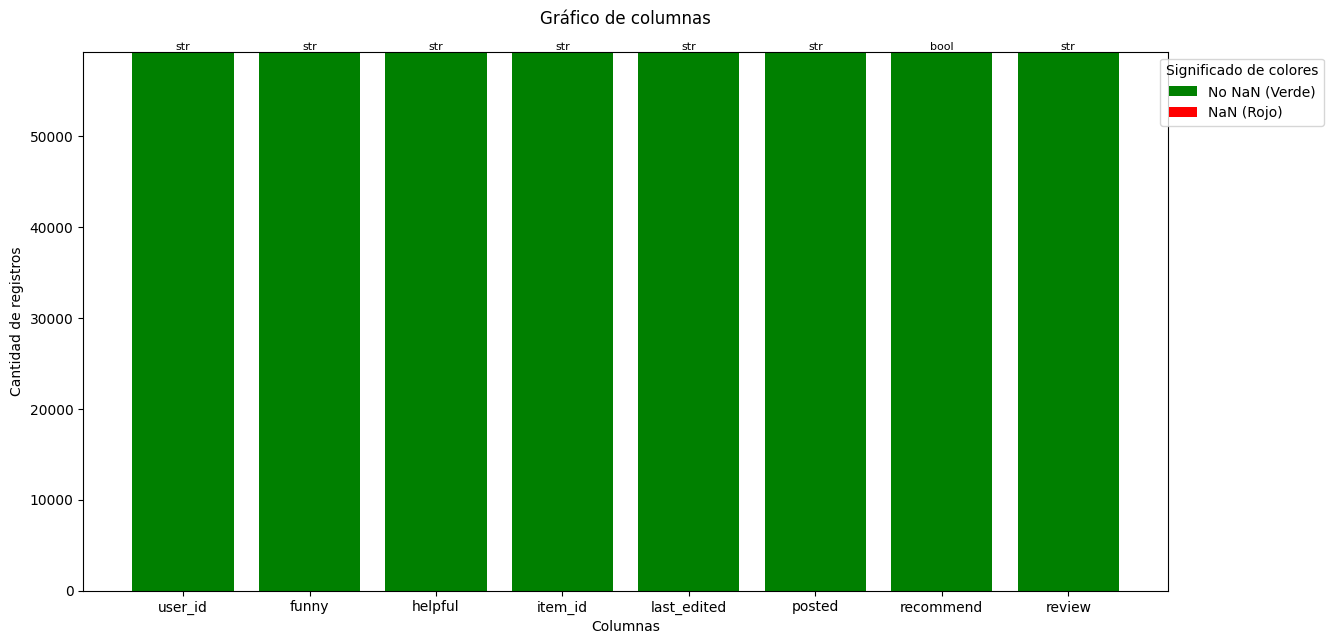

In [259]:
# Explode

# Desanidar la columna reviews en el mismo dataframe
user_reviews_df = pd.DataFrame(funciones.explode(user_reviews_df, 'reviews'))
'''
Nota: tener en cuenta que la funcion no imputa ningun registro si la lista en reviews esta vacía
'''

funciones.plot_df_info(user_reviews_df)

In [260]:
# Dimensiones post desanidación
user_reviews_df.shape

(59305, 8)

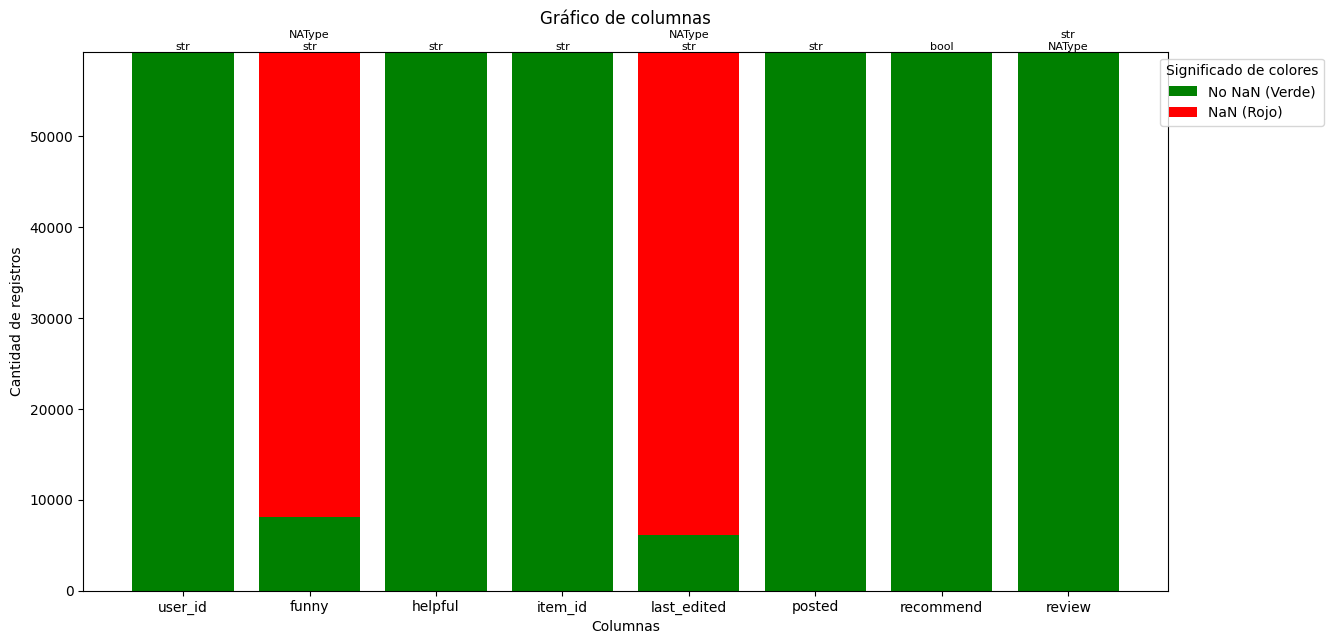

In [261]:
# Pasamos datos vacios a NaN
user_reviews_df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
funciones.plot_df_info(user_reviews_df)

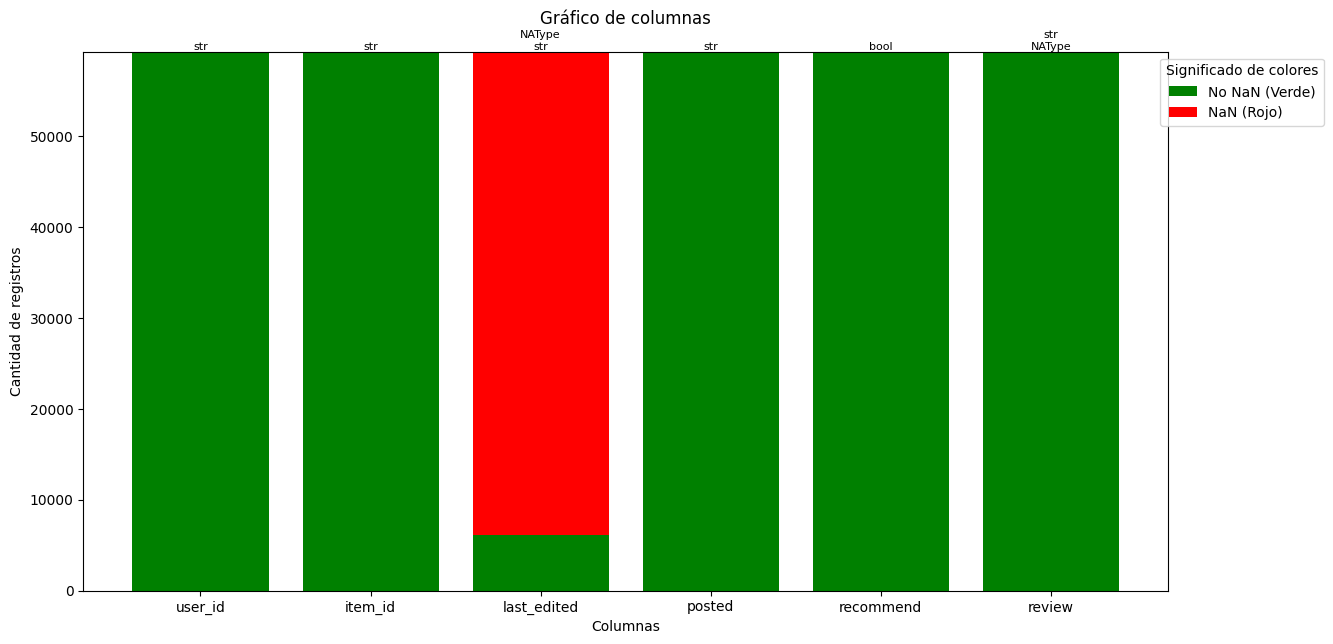

In [262]:
# Filtramos columnas que no vamos a utilizar, funny y helpful
user_reviews_df.drop(columns=['funny'], inplace=True)
user_reviews_df.drop(columns=['helpful'], inplace=True)
funciones.plot_df_info(user_reviews_df)

In [263]:
# user_reviews.user_id pasamos a tipo de dato int
user_reviews_df['item_id'] = user_reviews_df['item_id'].astype(int, errors='raise')

In [264]:
# user_reviews.last_edited, posted regularización de texto a año en int:

# Función para regularizar las cadenas de texto que contengan un numero consecutivo de longitud 4 entre 1950 y 2024
def regularize_date_from_4length_int_in_str(text):
    if pd.isna(text):
        return 0
    
    if isinstance(text, str):
        years_finded = []
        i = 0
        while i <= len(text) - 4:
            potential_year = text[i:i+4]
            if potential_year.isdigit():
                year = int(potential_year)
                if 1950 <= year <= 2024:
                    years_finded.append(year)
                    i += 4  # Skip the next 3 characters as we've identified a valid year
                else:
                    i += 1  # Continue checking the next character
            else:
                i += 1  # Continue checking the next character
        
        if len(years_finded) == 0:
            return 0 #np.na
        elif len(years_finded) == 1:
            return years_finded[0]
        else:
            return text
    
    return text  # For any other types, return the text as is

    # user_reviews.last_edited
# aplicación regularize_date_from_4length_int_in_str:
user_reviews_df['last_edited'] = user_reviews_df['last_edited'].apply(regularize_date_from_4length_int_in_str)

# Convertir la columna release_date a tipo int
user_reviews_df['last_edited'] = user_reviews_df['last_edited'].astype(int, errors='raise')


# Devolver los valores 0 a NaN
user_reviews_df['last_edited'] = user_reviews_df['last_edited'].replace(0, np.nan)

In [265]:
    # user_reviews.posted
# aplicación regularize_date_from_4length_int_in_str:
user_reviews_df['posted'] = user_reviews_df['posted'].apply(regularize_date_from_4length_int_in_str)

# Convertir la columna release_date a tipo int
user_reviews_df['posted'] = user_reviews_df['posted'].astype(int, errors='raise')


# Devolver los valores 0 a NaN
user_reviews_df['posted'] = user_reviews_df['posted'].replace(0, np.nan)

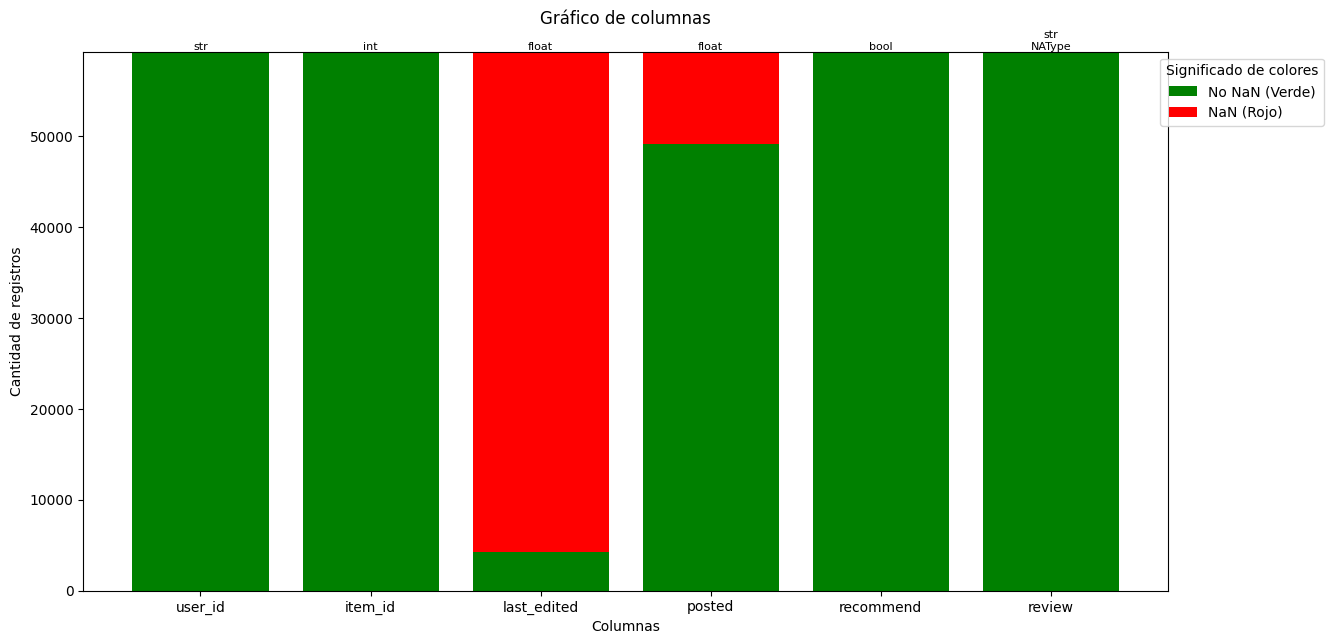

In [266]:
funciones.plot_df_info(user_reviews_df)

In [267]:
# Concatenar las columnas last_edited y posted en posted para actualizar la fecha de posteo a la mas actual

# Contador de inconsistencias
inconsistencies = 0

# Iterar sobre el DataFrame y procesar las columnas 'last_edited' y 'posted'
for index, row in user_reviews_df.iterrows():
    if pd.notna(row['last_edited']):
        if pd.isna(row['posted']):
            inconsistencies += 1
        else:
            user_reviews_df.at[index, 'posted'] = row['last_edited']

# Imprimir el número de inconsistencias
print(f'Inconsistencias encontradas: {inconsistencies}')

# Eliminar la columna 'posted' si no hay inconsistencias
if inconsistencies == 0:
    user_reviews_df.drop(columns=['last_edited'], inplace=True)


Inconsistencias encontradas: 0


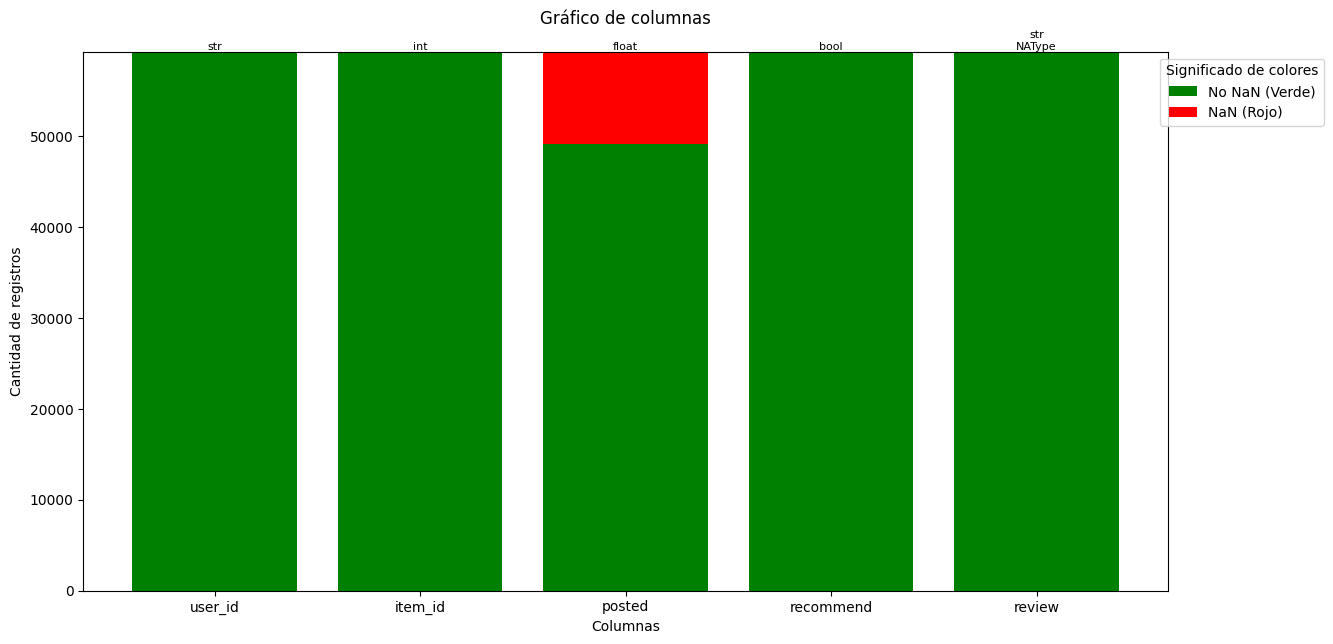

In [268]:
funciones.plot_df_info(user_reviews_df)

# Manejo de duplicados

In [269]:
user_reviews_df.shape

(59305, 5)

In [270]:
# Eliminar registros duplicados basados en todas las columnas
user_reviews_df.drop_duplicates(inplace=True)

In [271]:
user_reviews_df.shape

(58431, 5)

In [272]:
# Encuentra registros duplicados basados en las columnas 'item_id' y 'user_id'
duplicates = user_reviews_df.duplicated(subset=['item_id', 'user_id'], keep=False)

# Filtra el DataFrame original para mostrar solo los registros duplicados
duplicate_rows = user_reviews_df[duplicates]

if duplicate_rows.empty:
    print("No se encontraron registros duplicados basados en item_id y user_id")
else:
    print("Se encontraron registros duplicados basados en item_id y user_id")

No se encontraron registros duplicados basados en item_id y user_id


A partir de aca vamos a hacer la deteccion de idiomas y el analisis de sentimientos de las reviews


In [273]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

user_reviews_df['language'] = user_reviews_df['review'].apply(detect_language)

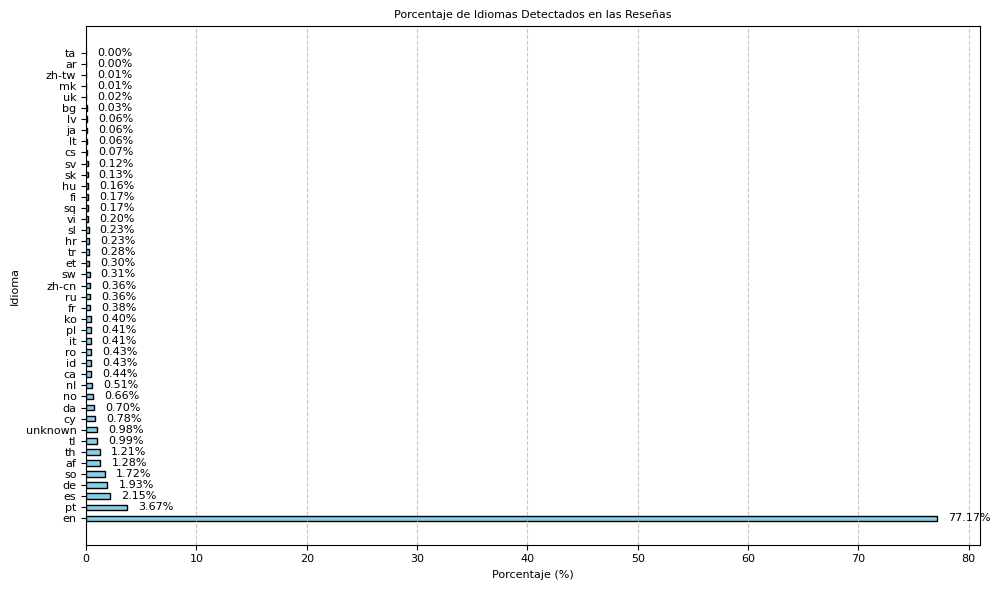

In [274]:
# Definir las variables
bar_width = 0.5  # Ancho de las barras
fontsize = 8  # Tamaño de fuente

# Obtener la cantidad total de reseñas
total_reviews = len(user_reviews_df)

# Calcular el porcentaje de cada idioma detectado
language_counts = user_reviews_df['language'].value_counts()
language_percentages = (language_counts / total_reviews) * 100

# Graficar los porcentajes de idiomas
plt.figure(figsize=(10, 6))
plt.barh(language_percentages.index, language_percentages, height=bar_width, color='skyblue', edgecolor='black', linewidth=1)
plt.title('Porcentaje de Idiomas Detectados en las Reseñas', fontsize=fontsize)
plt.xlabel('Porcentaje (%)', fontsize=fontsize)
plt.ylabel('Idioma', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Añadir etiquetas con los porcentajes
for i, percentage in enumerate(language_percentages):
    plt.text(percentage + 1, i, f'{percentage:.2f}%', va='center', fontsize=fontsize)

# Mostrar la gráfica
plt.show()


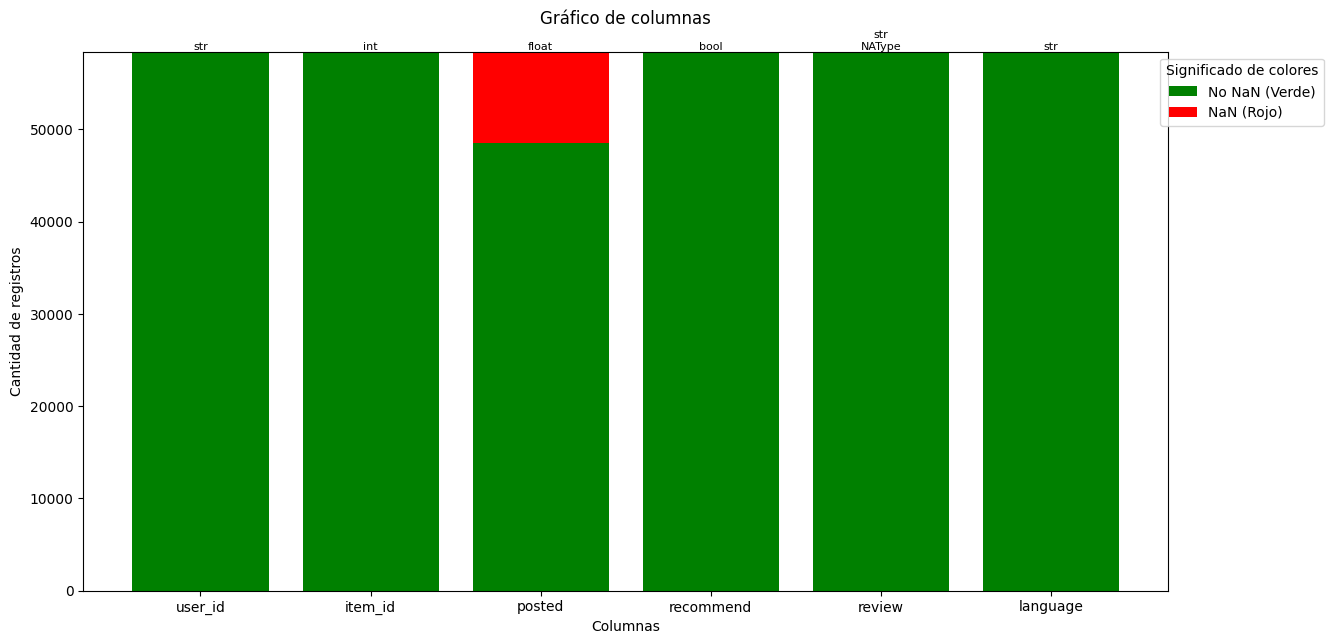

In [275]:
funciones.plot_df_info(user_reviews_df)

In [276]:
"""
Como mas del 70% del idioma detectado es en ingles, primero vamos a aplicarle PNL a ello y disponibilizar esos datos, luego
iremos agregando soporte para los casos restantes pensando que es mas eficiente, si traducir al ingles y utilizar ntkl o si
ntkl u otra libreria tiene redes neuronales adecuadas para tal idioma
"""

# Crear una instancia del analizador de sentimientos de NLTK (VADER)
sid = SentimentIntensityAnalyzer()

# Definir una lista para almacenar las inconsistencias
inconsistencies = []

# Definir una función para asignar el valor del sentimiento
def assign_sentiment_english_and_nan(row):
    review = row['review']
    recommend = row['recommend']
    language = row['language']

    # Si no hay datos en review toma un score en base a user_reviews_df.recommend
    if pd.isna(review):
        if recommend:
            return 2  # Positivo si recommend=True
        else:
            return 0  # Negativo si recommend=False
        
    # Si el dato no es nulo, comprueba que el lenguaje que se esta evaluando sea inglés
    if language == 'en':
        sentiment_score = sid.polarity_scores(review)['compound']
        if sentiment_score >= 0.05:
            sentiment_value = 2  # Positivo
        elif sentiment_score <= -0.05:
            sentiment_value = 0  # Negativo
        else:
            sentiment_value = 1  # Neutral

        # Capturar inconsistencias
        if (sentiment_value == 2 and not recommend) or (sentiment_value == 0 and recommend):
            inconsistencies.append(row)
        return sentiment_value
    
    # Si el idioma no es inglés ni nulo, devolvuelve pd.na
    else: 
        return pd.NA

# Aplicar la función a cada fila del DataFrame y crear la nueva columna 'sentiment_analysis'
user_reviews_df['sentiment_analysis'] = user_reviews_df.apply(assign_sentiment_english_and_nan, axis=1)

# Convertir las inconsistencias capturadas a un DataFrame
inconsistencies_df = pd.DataFrame(inconsistencies)

# Imprimir el número de inconsistencias encontradas
print(f'Número de inconsistencias encontradas: {len(inconsistencies_df)}')

# Mostrar los primeros registros para verificar
print(user_reviews_df.head())


Número de inconsistencias encontradas: 7855
             user_id  item_id  posted  recommend  \
0  76561197970982479     1250  2011.0       True   
1  76561197970982479    22200  2011.0       True   
2  76561197970982479    43110  2011.0       True   
3            js41637   251610  2014.0       True   
4            js41637   227300  2013.0       True   

                                              review language  \
0  Simple yet with great replayability. In my opi...       en   
1               It's unique and worth a playthrough.       en   
2  Great atmosphere. The gunplay can be a bit chu...       en   
3  I know what you think when you see this title ...       en   
4  For a simple (it's actually not all that simpl...       en   

  sentiment_analysis  
0                  2  
1                  2  
2                  2  
3                  2  
4                  2  


In [277]:
user_reviews_df

,user_id,item_id,posted,recommend,review,language,sentiment_analysis
0,76561197970982479,1250,2011.0,True,Simple yet with great replayability. In my opi...,en,2
1,76561197970982479,22200,2011.0,True,It's unique and worth a playthrough.,en,2
2,76561197970982479,43110,2011.0,True,Great atmosphere. The gunplay can be a bit chu...,en,2
3,js41637,251610,2014.0,True,I know what you think when you see this title ...,en,2
4,js41637,227300,2013.0,True,For a simple (it's actually not all that simpl...,en,2
...,...,...,...,...,...,...,...
59300,76561198312638244,70,NaN,True,a must have classic from steam definitely wort...,en,2
59301,76561198312638244,362890,NaN,True,this game is a perfect remake of the original ...,en,2
59302,LydiaMorley,273110,NaN,True,had so much fun plaing this and collecting res...,en,2
59303,LydiaMorley,730,NaN,True,:D,de,<NA>


In [282]:
inconsistencies_df

,user_id,item_id,posted,recommend,review,language
59304,LydiaMorley,440,NaN,True,so much fun :D,es
59304,LydiaMorley,440,NaN,True,so much fun :D,es
59304,LydiaMorley,440,NaN,True,so much fun :D,es
59304,LydiaMorley,440,NaN,True,so much fun :D,es
59304,LydiaMorley,440,NaN,True,so much fun :D,es
...,...,...,...,...,...,...
59304,LydiaMorley,440,NaN,True,so much fun :D,es
59304,LydiaMorley,440,NaN,True,so much fun :D,es
59304,LydiaMorley,440,NaN,True,so much fun :D,es
59304,LydiaMorley,440,NaN,True,so much fun :D,es


In [ ]:
"""
mi datframe de inconsistencias apunta a una sola usuaria con redundancia y yo ya maneja duplicados, por lo cual hago algunas
comprobaciones en mi dataframe original y si no encuentro ninguna inconsistencia sigo
"""

In [287]:
mask = inconsistencies_df[inconsistencies_df["user_id"] != 'LydiaMorley']
mask

,user_id,item_id,posted,recommend,review,language


In [286]:
mask = user_reviews_df[user_reviews_df["user_id"] == 'LydiaMorley']
mask

,user_id,item_id,posted,recommend,review,language,sentiment_analysis
59302,LydiaMorley,273110,NaN,True,had so much fun plaing this and collecting res...,en,2
59303,LydiaMorley,730,NaN,True,:D,de,<NA>
59304,LydiaMorley,440,NaN,True,so much fun :D,es,<NA>


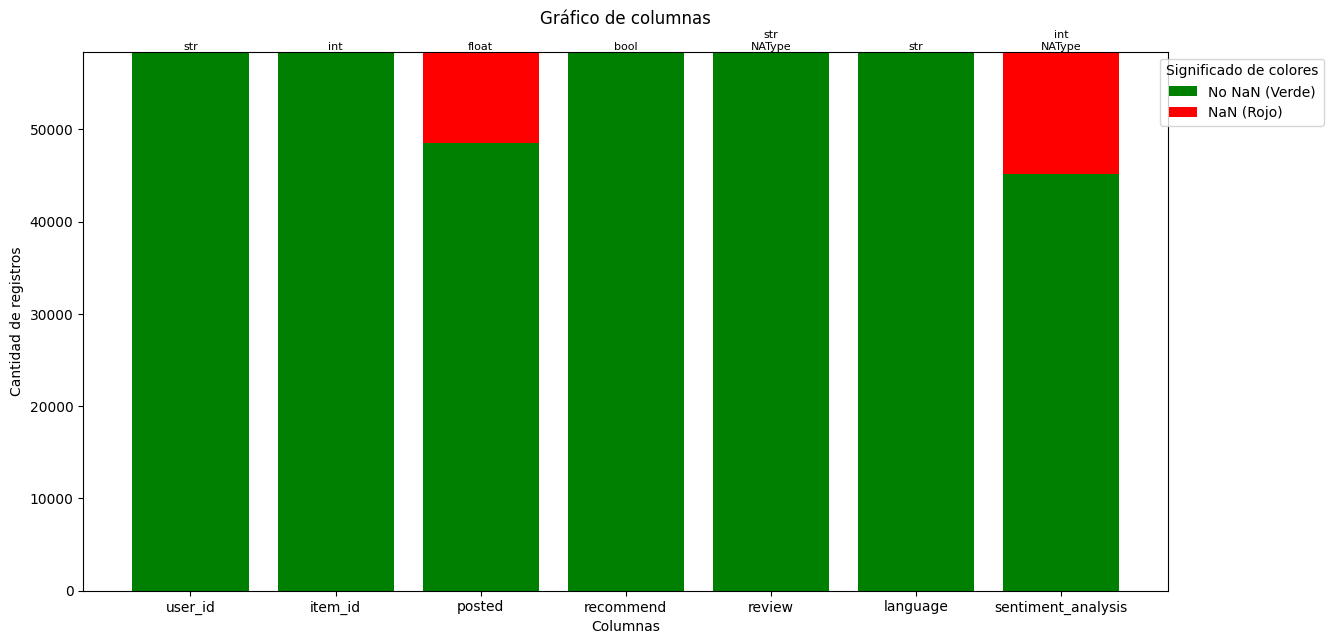

In [288]:
funciones.plot_df_info(user_reviews_df)

In [289]:
# Guardamos user_items_df en user_info.parquet
user_reviews_df.to_parquet(ruta_user_reviews, index=False)